In [1]:
#Pre-requisites to create the environement variables env.text in the same folder as the notebook
#Example of content in env.txt
#vzpoc_AZURE_TENANT_ID = 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx'
#vzpoc_AZURE_CLIENT_ID = 'yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy'
#vzpoc_AZURE_CLIENT_SECRET = 'zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz'
#vzpoc_AZURE_WORKSPACE_ID = 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa'

In [2]:
def get_dates():
    date_start = input("Starting date - Format of request (EST date): '2023-01-07 09:00')")
    date_end = input("Ending date - Format of request (EST date): '2023-01-07 19:00')")
    #return (date_start, date_end)
    return (str(date_start), str(date_end))

In [3]:
#ref: import requests
import hashlib
import hmac
import base64
import logging
import urllib3
import json
import datetime
import requests
import hashlib
import hmac
import base64
import logging
import urllib3
import json
import datetime
from datetime import datetime, timezone, timedelta
import pytz
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels as sm

def get_token(tenant, sp_id, sp_secret):
    """Obtain authentication token using a Service Principal"""
    login_url = "https://login.microsoftonline.com/"+tenant+"/oauth2/token"
    resource = "https://api.loganalytics.io"

    payload = {
        'grant_type': 'client_credentials',
        'client_id': sp_id,
        'client_secret': sp_secret,
        'Content-Type': 'x-www-form-urlencoded',
        'resource': resource
    }
    urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
    try:
        response = requests.post(login_url, data=payload, verify=False)
        
    except Exception as error:
        logging.error(error)
    
    if (response.status_code >= 200 and response.status_code <= 299):
        logging.info('Token obtained')
        token = json.loads(response.content)["access_token"]
        return {"Authorization": str("Bearer "+ token), 'Content-Type': 'application/json'}
    else:
        logging.error("Unable to Read: " + format(response.status_code))

def get_data(query, token, azure_log_customer_id):
    """Executes a KQL on a Azure Log Analytics Workspace
    
    Keyword arguments:
    query -- Kusto query to execute on Azure Log Analytics
    token -- Authentication token generated using get_token
    azure_log_customer_id -- Workspace ID obtained from Advanced Settings
    """
    
    az_url = "https://api.loganalytics.io/v1/workspaces/"+ azure_log_customer_id + "/query"
    query = {"query": query}

    try:
        response = requests.get(az_url, params=query, headers=token)
    except Exception as error:
        logging.error(error)
    
    if (response.status_code >= 200 and response.status_code <= 299):
        logging.info('Query ran successfully')
        return json.loads(response.content)
    else:
        logging.error("Unable to Read: " + format(response.status_code))

In [11]:
def get_graph(environment):
    #ref: import requests
    import hashlib
    import hmac
    import base64
    import logging
    import urllib3
    import json
    import datetime
    import requests
    import hashlib
    import hmac
    import base64
    import logging
    import urllib3
    import json
    import datetime
    from datetime import datetime, timezone, timedelta
    import pytz
    import numpy as np
    import matplotlib.pyplot as plt
    import pandas as pd
    import seaborn as sns
    import statsmodels as sm
    import matplotlib.ticker as plticker
    import datetime
    import matplotlib.dates as mdates
    import imp

    #Get Microsoft Azure environement variables (see pre-requisites to create the environement variables)
    env = imp.load_source('env','env.txt')
    environment = environment

    #Get Starting and ending dates
    date_start, date_end = get_dates()
    d1=date_start
    d2=date_end
    
    #Choose the environment LAB or NP
    if (environment == 'LAB'):

        AZURE_TENANT_ID = env.vzpoc_AZURE_TENANT_ID
        AZURE_CLIENT_ID = env.vzpoc_AZURE_CLIENT_ID
        AZURE_CLIENT_SECRET = env.vzpoc_AZURE_CLIENT_SECRET
        azure_log_customer_id = env.vzpoc_AZURE_WORKSPACE_ID
    else:
        AZURE_TENANT_ID = env.vzpmec_AZURE_TENANT_ID
        AZURE_CLIENT_ID = env.vzpmec_AZURE_CLIENT_ID
        AZURE_CLIENT_SECRET = env.vzpmec_AZURE_CLIENT_SECRET
        azure_log_customer_id = env.vzpmec_AZURE_WORKSPACE_ID
    
    #Set time zone to EST
    ESTTimeDelta = datetime.timedelta(hours=-5)
    ESTTZObject = datetime.timezone(ESTTimeDelta,name="EST")
  
    #Convert string date to to datetime
    #date_start=datetime.datetime.strptime(date_start, '%Y-%m-%d')
    #date_end=datetime.datetime.strptime(date_end, '%Y-%m-%d')
    #d1=date_start
    #d2=date_end
    date_start=datetime.datetime.strptime(date_start, '%Y-%m-%d %H:%M')
    date_end=datetime.datetime.strptime(date_end, '%Y-%m-%d %H:%M')

    #Convert from EST to UTC time
    date_start=date_start + timedelta(hours=5)
    date_end=date_end + timedelta(hours=5)

    #Convert back to string
    date_start=date_start.strftime("%m/%d/%Y, %H:%M:%S")
    date_end=date_end.strftime("%m/%d/%Y, %H:%M:%S")
    
    #Remove the warning for chained changes
    #https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas
    pd.options.mode.chained_assignment = None
    
    #Collect dataset
    query_Sessions = "MicrosoftAzureBastionAuditLogs | project ClientIpAddress, Duration, Protocol, SessionStartTime, SessionEndTime, OperationName, UserName, Message,TargetVMIPAddress, _ResourceId | where SessionStartTime >= datetime('"+date_start+"')| where SessionStartTime <= datetime('" +date_end+"')"
    
    #Get Microsoft Azure Access Token
    sp_token = get_token(AZURE_TENANT_ID, sp_id=AZURE_CLIENT_ID, sp_secret=AZURE_CLIENT_SECRET)

    #Get the data using the Microsoft Azure environement variables and the Access token
    data_Sessions = get_data(query=query_Sessions,token=sp_token, azure_log_customer_id=azure_log_customer_id)
    
    #Format the data
    #Create the dataframe
    df1=pd.DataFrame.from_dict(data_Sessions['tables'])
    df_data_Sessions=pd.DataFrame(df1['rows'][0])
    df_data_Sessions=df_data_Sessions.rename(columns={0: "ClientIpAddress", 1: "Duration", 2: "Protocol", 3: "SessionStartTime", 4: "SessionEndTime", 5: "OperationName", 6: "UserName", 7: "Message", 8: "TargetVMIPAddress", 9: "AzureBastion"})

    #Add Nan where string is empty
    df_data_Sessions=df_data_Sessions.mask(df_data_Sessions == '')

    #check there are sessions to be displayer
    if (df_data_Sessions.shape[0] > 0):
        #print (df_data_Sessions.shape[0])
    
        #Convert string time to datetime
        df_data_Sessions['SessionEndTime']=pd.to_datetime(df_data_Sessions['SessionEndTime'], format='%m/%d/%Y %I:%M:%S %p')
        df_data_Sessions['SessionStartTime']=pd.to_datetime(df_data_Sessions['SessionStartTime'], format='%Y-%m-%dT%H:%M:%S')

        #Set Timezone
        df_data_Sessions['SessionEndTime']=df_data_Sessions['SessionEndTime'].dt.tz_localize(timezone.utc)
        df_data_Sessions['SessionEndTime']=df_data_Sessions['SessionEndTime'].dt.tz_convert(ESTTZObject)
        df_data_Sessions['SessionStartTime']=df_data_Sessions['SessionStartTime'].dt.tz_convert(ESTTZObject)

        #Extract AzureBastion String name
        for ind in df_data_Sessions.index:
            df_data_Sessions['AzureBastion'][ind]=df_data_Sessions['AzureBastion'][ind].split('/')[-1]

        #Slice data to new DataFrame
        df_sessions=df_data_Sessions[['UserName','SessionStartTime', 'SessionEndTime', 'AzureBastion', 'TargetVMIPAddress']][(df_data_Sessions['Message']=='Successfully Disconnected')].sort_values(by='SessionStartTime', ascending=True).reset_index()
        
        # Plot the data in to a graph
        fig, ax = plt.subplots(figsize=(10,6))
        
        for ind in df_sessions.index:
            x = [df_sessions['SessionStartTime'][ind], df_sessions['SessionEndTime'][ind]]
            y = [ind+1, ind+1]
            ax.plot(x, y, linestyle='-', marker='')
            ax.text(x[0], y[0]+0.1, 'Session {} from {}\n using {} to connect to {}'.format(ind+1, df_sessions['UserName'][ind], df_sessions['AzureBastion'][ind], df_sessions['TargetVMIPAddress'][ind]), fontsize = 5)

        # Define the date format & Timezone
        my_tz = pytz.timezone('EST')
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%H:%M', tz=my_tz))            

        #x axis configuration
        ax.xaxis_date()
        hours = mdates.HourLocator(interval = 1)  #
        ax.xaxis.set_major_locator(hours)
        ax.xaxis.grid(linestyle='--', linewidth=0.5)
        ax.tick_params(axis='both', which='major', labelsize=7)
        ax.tick_params(axis='both', which='minor', labelsize=7)
        ax.set_xlim([df_sessions['SessionStartTime'].min()- timedelta(hours=0.5), df_sessions['SessionEndTime'].max() + timedelta(hours=5)])
        ax.set_xlabel('Sessions time (EST) & duration', fontsize=10)
        fig.autofmt_xdate() 
        
        #y axis configuration
        ax.set_ylim([0, df_sessions.shape[0] + 1])
        loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
        ax.yaxis.set_major_locator(loc)
        ax.set_ylabel('Sessions', fontsize='medium') 
        
        #Set Graph Title
        ax.set_title('{} Bastion Sessions from {} to {} EST'.format(df_sessions.shape[0], d1, d2))
    else:
        #print (df_sessions.shape[0])
        print ("There is no identified session in the chosen time range")

Starting date - Format of request (EST date): '2023-01-07 09:00')2023-01-07 09:00
Ending date - Format of request (EST date): '2023-01-07 19:00')2023-01-07 12:00


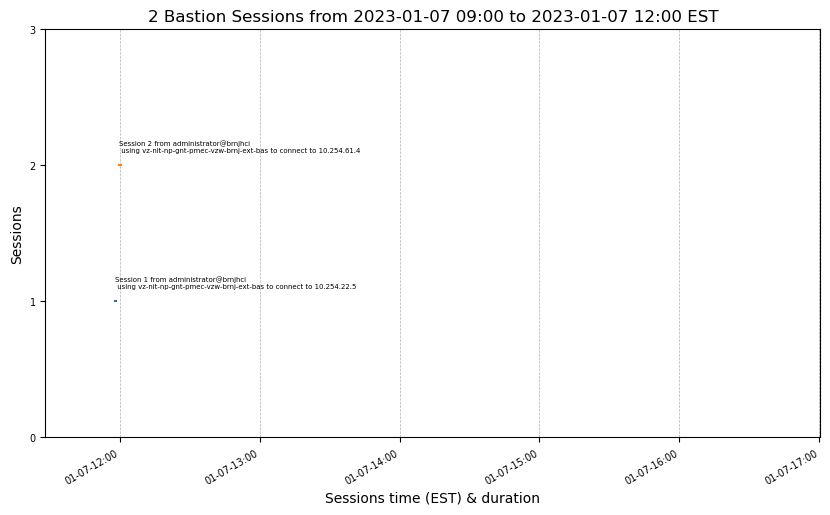

In [15]:
get_graph('LAB')
#get_graph('NP')